In [1]:
from cryodrgn import mrc
import matplotlib.pylab as plt
from scipy import ndimage
import plotly.express as px
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import glob
import plotly.colors as colors
import random

In [2]:
def plot_micrograph_array(rows, cols, selections, all_images, all_picks, fom_cut, figsize=(20,20), marker_size=200):
    f, axes = plt.subplots(rows,cols, figsize=figsize)
    axes = axes.flatten()
    for i in range(rows*cols):
        micrograph = mrc.parse_mrc(all_images[selections[i]])[0][0]
        low_image = ndimage.gaussian_filter(micrograph, lowpass_value)
        star = parse_star(all_picks[selections[i]])
        star_best = star[star['_rlnAutopickFigureOfMerit']>fom_cut]
        axes[i].imshow(low_image, cmap='gray', origin='lower')
        c = plt.cm.Reds(star_best['_rlnAutopickFigureOfMerit'])
        axes[i].scatter(star_best['_rlnCoordinateX'], star_best['_rlnCoordinateY'], s=marker_size, facecolors='none', edgecolors=c)
        axes[i].set_title(all_images[selections[i]])
        axes[i].axis('off')
    plt.tight_layout()

In [3]:
def interact_hist(star, bin_dict=None, default_bins=1000):
    fig = go.Figure()
    buttons = []
    i=0
    columns = star.describe().columns
    if bin_dict is None:
        bin_dict = {}
        for c in columns:
            bin_dict[c] = default_bins
            
    for i, column in enumerate(columns):
        fig.add_trace(go.Histogram(x=star[column], name=column, nbinsx=bin_dict[column]))
        visible = [False]*len(columns)
        visible[i] = True
        buttons.append(dict(label=column, method='update', args=[{'visible': visible}, {'title':'MotionStar', 'showlegend':True}]))

    fig.update_layout(updatemenus=[go.layout.Updatemenu(active=0,buttons=buttons)])
    fig.show()

In [4]:
def parse_star(star_path, loop_token='loop_', relevant_loop=-1):
    star_lines = open(star_path, 'r').readlines()
    loops = [i for i, x in enumerate(star_lines) if x.strip() == loop_token]
    headers = []
    index = loops[relevant_loop]+1
    field = star_lines[index].strip()
    while field[0] =='_':
        field = star_lines[index].strip()
        headers.append(field.split(' ')[0])
        index+=1
    star = pd.read_csv(star_path, skiprows=index-1, delim_whitespace=True, names=headers[:-1])
    return star

In [5]:
def parse_autopick_star(star_path, fom_limit, loop_token='loop_', relevant_loop=-1):
    star = parse_star(star_path, loop_token = loop_token, relevant_loop=relevant_loop)
    star['_good_picks'] = np.nan
    for row in star.index.values:
        autopick_star = parse_star(star.loc[row,'_rlnMicrographCoordinates'])
        pick_count = autopick_star[autopick_star['_rlnAutopickFigureOfMerit']>=fom_limit].shape[0]
        star.loc[row,'_good_picks'] = pick_count
    return star


In [6]:
def analyze_single_picks(pick_star, micrograph_mrc, num_steps=50, fig_size=750, top_fom=None, bottom_fom=None, rescale=False):
    star = parse_star(pick_star)
    micrograph = mrc.parse_mrc(micrograph_mrc)[0][0] #add correct path if necessary
    low_image = ndimage.gaussian_filter(micrograph, lowpass_value)
    
    mean = low_image.mean()
    std = low_image.std()
    if rescale:
        zmin = max(mean-4*std, low_image.min())
        zmax = min(mean+4*std, low_image.max())
    else:
        zmin = low_image.min()
        zmax = low_image.max()
    
    if top_fom is None:
        top_fom = star['_rlnAutopickFigureOfMerit'].max()
    if bottom_fom is None:
        bottom_fom = star['_rlnAutopickFigureOfMerit'].min()

    offset = (top_fom - bottom_fom)/num_steps

    bins = np.linspace(bottom_fom, top_fom, num=num_steps)

    #create figure, add image
    fig = px.imshow(low_image, binary_string=True, origin='lower', zmin=zmin, zmax=zmax)
    layout = go.Layout(autosize=False, width=fig_size,height=int(low_image.shape[0]/low_image.shape[1]*fig_size))
    
    if rescale:
        mean = low_image.mean()
        std = low_image.std()
        zmin = max(mean-4*std, low_image.min())
        zmax = min(mean+4*std, low_image.max())
    else:
        zmin = low_image.min()
        zmax = low_image.max()

    # Add traces, one for each slider step
    picks_per_step=[]
    for step, lower_bound in enumerate(np.arange(bottom_fom, top_fom, offset)):
        filt_star = star[star['_rlnAutopickFigureOfMerit']>=lower_bound]

        fig.add_trace(
            go.Scatter(visible=False,x=filt_star['_rlnCoordinateX'], y=filt_star['_rlnCoordinateY'],
                marker=go.scatter.Marker(
                    size=20,
                    color=filt_star['_rlnAutopickFigureOfMerit'],
                    colorscale='Jet',
                    cmin=-5,
                    cmax=5),
                mode='markers', 
                marker_symbol='circle-open'))
    
        picks_per_step.append(filt_star.shape[0])

    fig.data[0].visible = True
    fig.data[1].visible = True

    # Create and add slider
    steps = []
    for i in range(1,len(fig.data)):
        step = dict(
            method="update",
            args=[{"visible": [True] + [False] * (len(fig.data)-1)},
                  {"title": "Slider switched to FOM >=" + str(bins[i-1]) + 
                   '. total picks = ' + str(picks_per_step[i-1])}],  # layout attribute
        )
        step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [dict(active=0,currentvalue={"prefix": "FOM_minimum: "},pad={"t": 50},steps=steps)]
    fig.update_layout(layout,sliders=sliders)
    fig.show()


## Setup appropriate low-pass filtering
* First pick a representative micrograph and set sample_mrc to this name
* Second, provide the proper directory pointing to the Motion corrected micrographs
* Third, set the Ang/pix size and expected particle radius in angstroms
* Fourth, decide if you want to rescale the colors of the image
* Finally, inspect a full size image with your chosen low-pass value and repeat with a few random images

In [7]:
#####################################################
figsize = (20,20) #set this appropriately based on your screen size

images_path = './MotionCorr/job014/linked_images/' #set to your linked_images directory in the MotionCorr job you are analyzing
sample_mrc = '17dec13a_00174sq_v02_00008hl_00005es_frames.mrc' #fill this in with a representative micrograph name
pick_path = './AutoPick/job036/linked_images/' #fill me in
lowpass_range = [0, 2, 4, 8, 10, 12, 14, 16, 18] #change range of filtering if necessary

ang_px = 0.655 #fill me in - not currently used
particle_radius_A = 220 #fill me in - not currently used
######################################################

In [8]:
all_images = glob.glob(images_path+'*frames.mrc') #note your micrograph naming scheme if it differs
all_picks = [pick_path+i.split('/')[-1].split('.mrc')[0]+'_autopick.star' for i in all_images]
sm = mrc.parse_mrc(images_path+sample_mrc)[0][0]
particle_radius_px = particle_radius_A/ang_px

In [9]:
f, axes = plt.subplots(3,3, figsize=figsize)
for i in range(0,3):
    for j in range(0,3):
        axes[i][j].imshow(ndimage.gaussian_filter(sm, lowpass_range[i*3+j]), cmap='gray', origin='lower')
        axes[i][j].set_title('lowpass = ' + str(lowpass_range[i*3+j]))
        axes[i][j].axis('off')
plt.tight_layout()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/nobackup/users/bmp/software/anaconda3/envs/cryodrgn_cdcluster/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-3d51bafad442>", line 4, in <module>
    axes[i][j].imshow(ndimage.gaussian_filter(sm, lowpass_range[i*3+j]), cmap='gray', origin='lower')
  File "/nobackup/users/bmp/software/anaconda3/envs/cryodrgn_cdcluster/lib/python3.7/site-packages/scipy/ndimage/filters.py", line 343, in gaussian_filter
    mode, cval, truncate)
  File "/nobackup/users/bmp/software/anaconda3/envs/cryodrgn_cdcluster/lib/python3.7/site-packages/scipy/ndimage/filters.py", line 261, in gaussian_filter1d
    return correlate1d(input, weights, axis, output, mode, cval, 0)
  File "/nobackup/users/bmp/software/anaconda3/envs/cryodrgn_cdcluster/lib/python3.7/site-packages/scipy/ndimage/filters.py", line 134, in correlate1d
    origin)
KeyboardInterrupt

Dur

TypeError: object of type 'NoneType' has no len()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error in callback <function flush_figures at 0x7f10b4728560> (for post_execute):



KeyboardInterrupt



In [10]:
################################
lowpass_value = 8#Fill this in to your chosen value
################################

In [14]:
low_image = ndimage.gaussian_filter(sm, lowpass_value)
#f, axes = plt.subplots(1,1, figsize=figsize)
#axes.imshow(low_image, cmap='gray', origin='lower')
#axes.set_title('lowpass = ' + str(lowpass_value))
#axes.axis('off')
#plt.tight_layout()

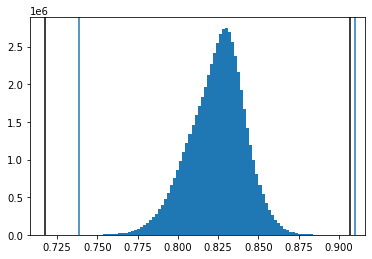

In [15]:
f, ax = plt.subplots(1,1)
mean = low_image.mean()
std = low_image.std()
zmin = mean-5*std
zmax = mean+5*std
ax.hist(low_image.flatten(), bins=100)
ax.axvline(zmin)
ax.axvline(low_image.min(), color='black')
ax.axvline(zmax)
ax.axvline(low_image.max(), color='black')

In [11]:
#############################
rescale=False #set this to true if you think you have outlier particles and want to focus the range on the signal in the image
#############################

In [ ]:
f, axes = plt.subplots(1,1, figsize=figsize)
axes.imshow(low_image, cmap='gray', origin='lower', vmin=zmin, vmax=zmax)
axes.set_title('lowpass = ' + str(lowpass_value) + ' : rescale = ' + str(rescale))
axes.axis('off')
plt.tight_layout()

In [ ]:
#############################
rows=2 #set me
cols=2 #set me
#############################

In [ ]:
images

In [ ]:
f, axes = plt.subplots(rows,cols, figsize=figsize)
axes = axes.flatten()
images = np.random.choice(all_images, size=rows*cols, replace=False)
for i in range(rows*cols):
    sm = mrc.parse_mrc(images[i])[0][0]
    lpi = ndimage.gaussian_filter(sm, lowpass_value)
    axes[i].imshow(lpi, cmap='gray', origin='lower', vmin=zmin, vmax=zmax)
    axes[i].set_title(images[i])
    axes[i].axis('off')
plt.tight_layout()

## Inspect sample picks
* First, fill in the apporopriate path to your autopick job (Autopic/jobxxx/linked_images/).
* Second, look at the distribution of rlnAutopickFigureOfMerit scores, and pick a cuttoff that you think corresponds to "good" picks

In [ ]:
################################
bins = 40 #may need to adjust the bins in the histogram
thresh = 0 #change this to set your threshold (better than this number are 'good' picks)
################################

In [ ]:
sample_mrc = '17dec13a_00178sq_v02_00014hl_00002es_frames.mrc'
sample_micrograph = mrc.parse_mrc(images_path+sample_mrc)[0][0]
low_image = ndimage.gaussian_filter(sample_micrograph, lowpass_value)
example_pick_star_path = pick_path+sample_mrc.split('.mrc')[0]+'_autopick.star'
example_pick_star = parse_star(example_pick_star_path)
#ax = sns.histplot(data=example_pick_star, x="_rlnAutopickFigureOfMerit", bins=bins)
#ax.axvline(thresh, color='black')
#ax.set_title(example_pick_star_path)
star_best = example_pick_star[example_pick_star['_rlnAutopickFigureOfMerit']>thresh]
f, axes = plt.subplots(1,1, figsize=figsize)
axes.imshow(low_image, cmap='gray', origin='lower', vmin=zmin, vmax=zmax)
#axes.set_title(example_pick_star_path)
plt.savefig('/home/jhdavis/example_micrograph_nopicks.png')
c = plt.cm.Reds(star_best['_rlnAutopickFigureOfMerit'])
#axes.scatter(star_best['_rlnCoordinateX'], 
#             star_best['_rlnCoordinateY'], s=200,
#             facecolors='none', edgecolors=c)

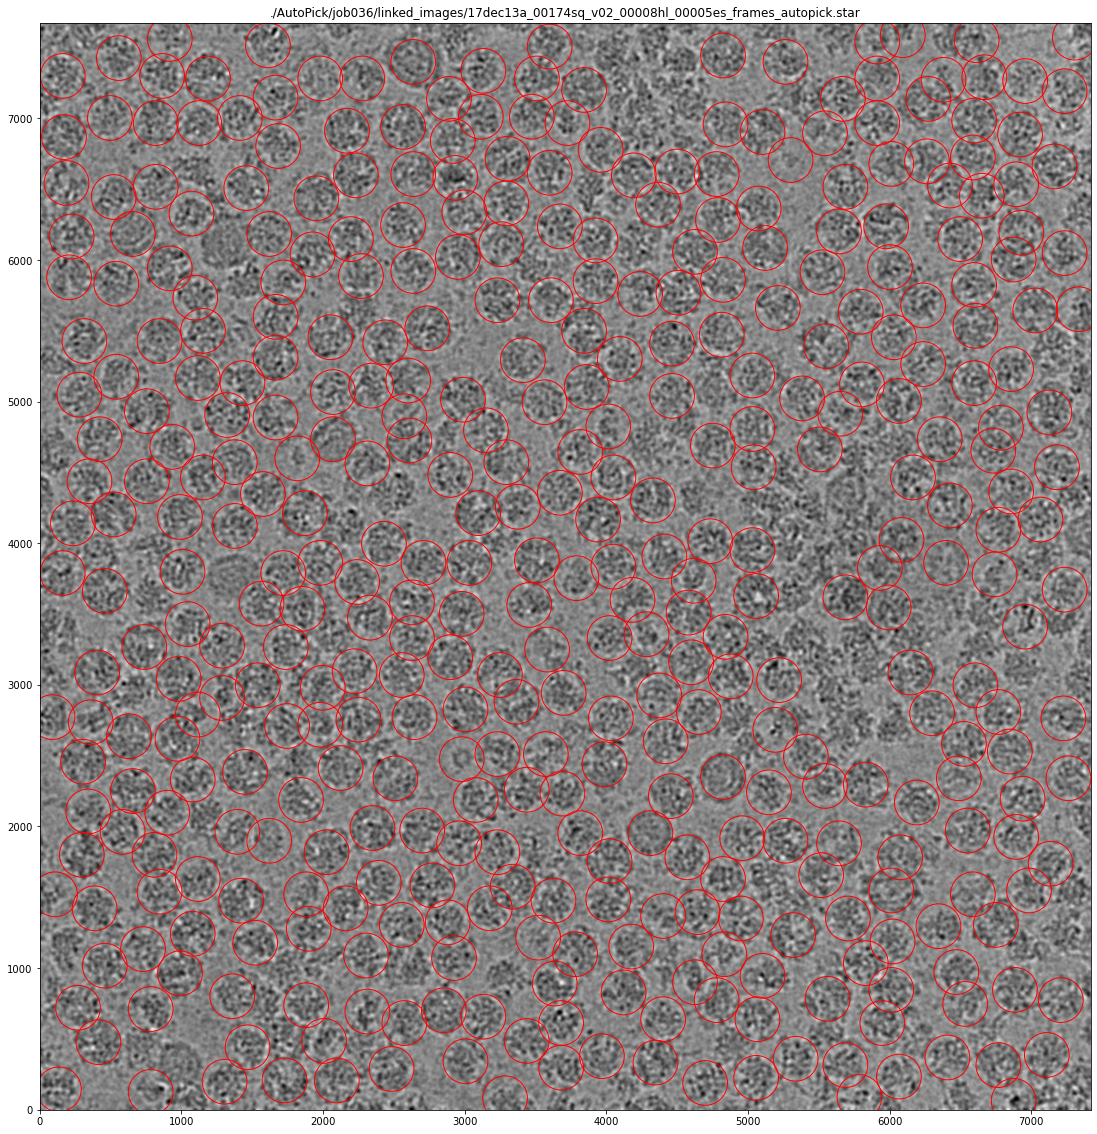

In [16]:
sample_micrograph = mrc.parse_mrc(images_path+sample_mrc)[0][0]
low_image = ndimage.gaussian_filter(sample_micrograph, lowpass_value)
example_pick_star_path = pick_path+sample_mrc.split('.mrc')[0]+'_autopick.star'
example_pick_star = parse_star(example_pick_star_path)
thresh = 1
star_best = example_pick_star[example_pick_star['_rlnAutopickFigureOfMerit']>thresh]
f, axes = plt.subplots(1,1, figsize=figsize)
axes.imshow(low_image, cmap='gray', origin='lower', vmin=zmin, vmax=zmax)
axes.set_title(example_pick_star_path)
axes.scatter(star_best['_rlnCoordinateX'], 
             star_best['_rlnCoordinateY'], s=2000,
             facecolors='none', edgecolors='red')
plt.savefig('/home/jhdavis/example_micrograph_2000_picks.png')

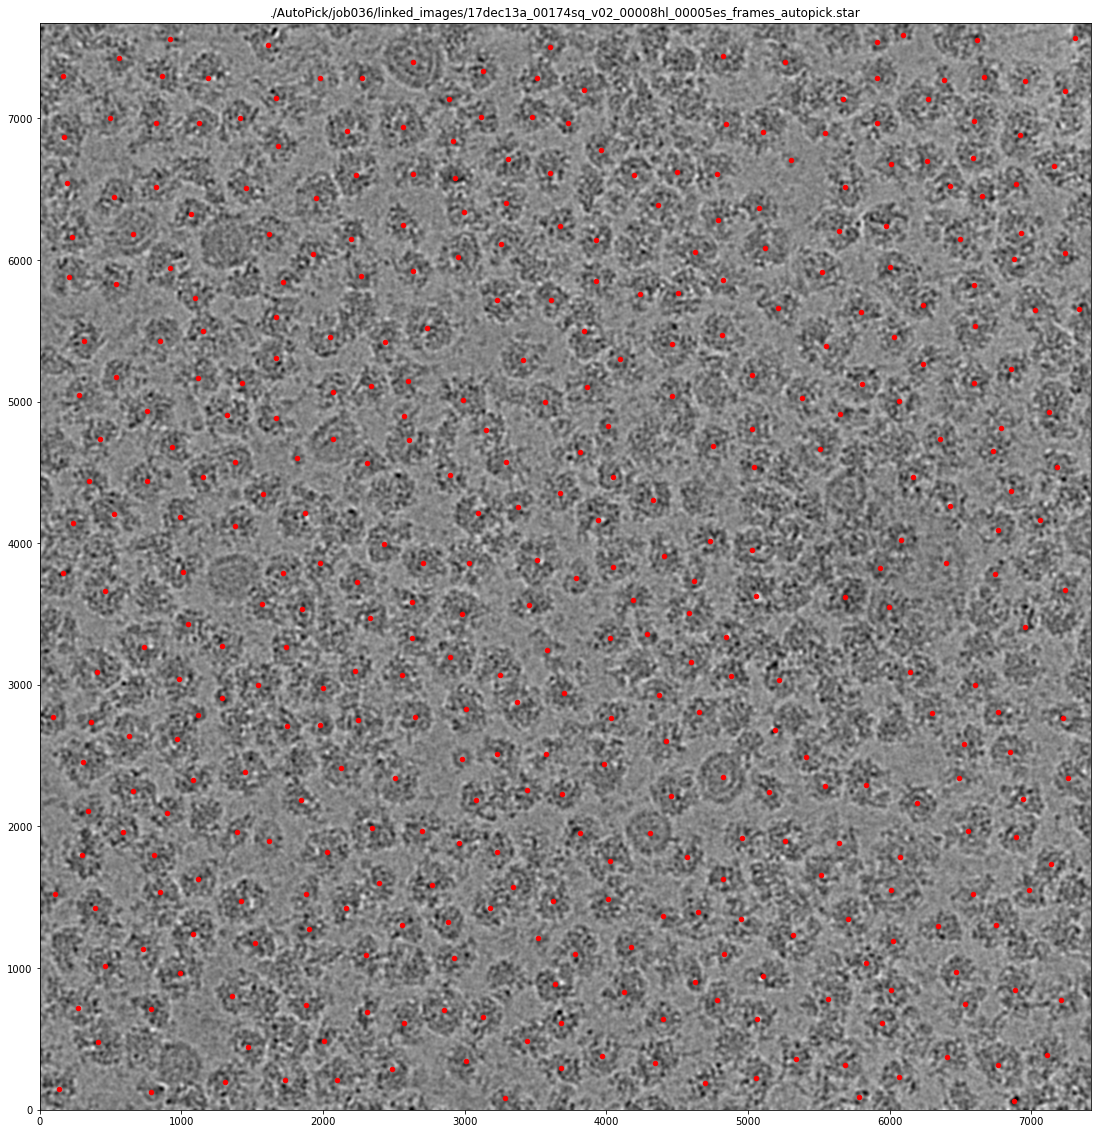

In [17]:
sample_micrograph = mrc.parse_mrc(images_path+sample_mrc)[0][0]
low_image = ndimage.gaussian_filter(sample_micrograph, lowpass_value)
example_pick_star_path = pick_path+sample_mrc.split('.mrc')[0]+'_autopick.star'
example_pick_star = parse_star(example_pick_star_path)
thresh = 1
star_best = example_pick_star[example_pick_star['_rlnAutopickFigureOfMerit']>thresh]
f, axes = plt.subplots(1,1, figsize=figsize)
axes.imshow(low_image, cmap='gray', origin='lower', vmin=zmin, vmax=zmax)
axes.set_title(example_pick_star_path)
axes.scatter(star_best['_rlnCoordinateX'], 
             star_best['_rlnCoordinateY'], s=20,
             facecolors='red', edgecolors='red')
plt.savefig('/home/jhdavis/example_micrograph_20_picks.png')

## Interactively choose FOM threshold

In [ ]:
random_image_index = random.choice(range(len(all_images)))
print(all_images[random_image_index] + ' | ' + str(random_image_index))
analyze_single_picks(all_picks[random_image_index], all_images[random_image_index], bottom_fom=-3)

## Inspect applied picks
* Choose a number of rows and columns of full frame micrographs to inspect
* Set a figure size (typically much larger than your screen so you can see fine detail when the image is full size)
* Optionally set seletcions as the indices of the micrographs you'd like to inspect (by default, a random set is chosen)

In [ ]:
################################
fom_cut = -0.3 # set me at the desired figure of merit cutoff
rows=2 # set me
cols=2 # set me
figsize=(30,30) # set me
marker_size=200 #set me to change marker size
selections = np.random.choice(range(len(all_images)), size=rows*cols) # optionally set me to defined indices. inspect the all_images array to see the filenames
################################

In [ ]:
plot_micrograph_array(rows, cols, selections, all_images, all_picks, fom_cut)

## Curate micrographs
* Here, we will use statistics from particle counts, motion correction, and ctf estimation, to select our micrographs of interest. Only these will be used for the final extractions
* We start by inspecting particle counts - typically those with very few picks (out of distribution) are poor micrographs

In [ ]:
################################
fom_cut = -.3 # set me at the desired figure of merit cutoff
autopick_star_file = './AutoPick/job036/autopick.star' # fill me in correctly
################################

In [ ]:
autopick_star = parse_autopick_star(autopick_star_file, fom_cut)
sns.histplot(autopick_star['_good_picks'])

In [ ]:
#################
figsize=(10,10)
rows=3
cols=3
field = '_good_picks'
select_range = (0,200)
#################

In [ ]:
excluded_micrographs_particle_count = autopick_star.loc[autopick_star[field].between(select_range[0], select_range[1]), '_rlnMicrographName']
selections_named = np.random.choice(excluded_micrographs_particle_count, size=rows*cols)
all_images_clean = [i.split('/')[-1] for i in all_images]
selections = [all_images_clean.index(i.split('/')[-1]) for i in selections_named]

print('excluding ' + str(excluded_micrographs_particle_count.shape[0]) + ' micrographs based on particle count.')
print('excluded micrographs are:')
print(excluded_micrographs_particle_count.values)

In [ ]:
print(p)
if len(selections) >= rows*cols:
    plot_micrograph_array(rows,cols, selections, all_images, all_picks, fom_cut)

In [ ]:
#########################
motion_star_path = './MotionCorr/job014/corrected_micrographs.star' #set me
ctf_star_path = './CtfFind/job021/micrographs_ctf.star' #set me
default_bins = 100 #set me to a new value if needed
#########################

In [ ]:
motion_star = parse_star(motion_star_path)
ctf_star = parse_star(ctf_star_path)

In [ ]:
interact_hist(motion_star, default_bins=default_bins)

In [ ]:
#################
all_fields = motion_star.describe().columns
figsize=(10,10)
rows=3
cols=3
field = '_rlnAccumMotionTotal'
select_range = (100,300)
#################
print(all_fields)

In [ ]:
motion_star.iloc[selections]

In [ ]:
selections = np.random.choice(motion_star[motion_star[field].between(select_range[0], select_range[1])].index, size=rows*cols)
if selections.shape[0] >= rows*cols:
    plot_micrograph_array(rows,cols, selections, all_images, all_picks, fom_cut)

In [ ]:
##############
im